In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset,WeightedRandomSampler
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
review_df=pd.read_csv('processed_data.csv',index_col=False)

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Function for preprocessing without tokenizing
def preprocess_text_no_tokenize(text):

    # Remove stop words and perform other preprocessing
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    # Remove punctuation
    text = text.replace('[^a-zA-Z]', ' ')
    # Remove stop words
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]

    # Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Join the lemmatized words back into a single string
    preprocessed_text = ' '.join(lemmatized_words)

    return preprocessed_text

# Apply the preprocessing function to the 'review_text' column
review_df['review_text'] = review_df['review_text'].apply(preprocess_text_no_tokenize)

review_df.head()

,Unnamed: 0,unique_id,review_text,rating,sentiment
0,0,B000FVEL7W:the_best:ronald_t._hicks,"best product preventing ridding red bumps, ing...",5.0,positive
1,1,B000GBID20:pleased_with_oral_b_vitality_sonic:...,looking something le abrasive regular manual t...,4.0,positive
2,2,"B0009IK198:a_fine_shave:thomas_m._stevens_""mic...",bought razor check foil shave. I've used Norel...,4.0,positive
3,3,B000BPU3KG:best_one_there_is:sarah_j._moseley_...,fibromyalgia heating pad closest friends. : ) ...,5.0,positive
4,4,"B000195OCO:just_trust_me...:shilo_irving_""u4ic...",one around fragrance man have. lumberjack busi...,5.0,positive


# Load pre-trained DistilBERT model and tokenizer

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Split the data into features and target variable

In [6]:
X = review_df['review_text']
y = review_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(5780,) (1445,) (5780,) (1445,)


Tokenizing the text using distilbert tokenizer

In [7]:
X_train_tokens = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
X_test_tokens = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='pt')

y_train_tensor = torch.tensor(y_train.map({'positive': 1, 'negative': 0}).values)
y_test_tensor = torch.tensor(y_test.map({'positive': 1, 'negative': 0}).values)

Attention Masking

In [8]:
train_dataset = TensorDataset(X_train_tokens['input_ids'], X_train_tokens['attention_mask'], y_train_tensor)
test_dataset = TensorDataset(X_test_tokens['input_ids'], X_test_tokens['attention_mask'], y_test_tensor)

Compute class weights to handle class imbalance and Creating a WeightedRandomSampler

In [9]:
class_weights = torch.tensor([1.0, len(y_train) / len(y_train[y_train == 'positive'])], dtype=torch.float)
sample_weights = class_weights[y_train.map({'positive': 1, 'negative': 0}).values]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Defining DataLoader for training and testing set with the weighted sampler

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training the BERT using Reptile

In [11]:
# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# Set up Reptile parameters
meta_learning_rate = 0.001
meta_epochs = 1

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
for meta_epoch in range(meta_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        print(f"Training Loss: {loss.item():.4f}")
        loss.backward()
        optimizer.step()

        # Perturb the model parameters towards the current batch
        for param in model.parameters():
            param.data = param.data + (param.data - param.data) * random.uniform(0, 0.1)
print('Bert has been trained!')

Training Loss: 0.6442
Training Loss: 0.5904
Training Loss: 0.5524
Training Loss: 0.4728
Training Loss: 0.4256
Training Loss: 0.3826
Training Loss: 0.4162
Training Loss: 0.5470
Training Loss: 0.3279
Training Loss: 0.5690
Training Loss: 0.4996
Training Loss: 0.4406
Training Loss: 0.4349
Training Loss: 0.4309
Training Loss: 0.5422
Training Loss: 0.6216
Training Loss: 0.5433
Training Loss: 0.3954
Training Loss: 0.4259
Training Loss: 0.5162
Training Loss: 0.4060
Training Loss: 0.6745
Training Loss: 0.3994
Training Loss: 0.5054
Training Loss: 0.3736
Training Loss: 0.7307
Training Loss: 0.3892
Training Loss: 0.4635
Training Loss: 0.4700
Training Loss: 0.4342
Training Loss: 0.3394
Training Loss: 0.4008
Training Loss: 0.2752
Training Loss: 0.7686
Training Loss: 0.5810
Training Loss: 0.3669
Training Loss: 0.3817
Training Loss: 0.3596
Training Loss: 0.3078
Training Loss: 0.5542
Training Loss: 0.4012
Training Loss: 0.4284
Training Loss: 0.3968
Training Loss: 0.4310
Training Loss: 0.4657
Training L

Evaluating the fine-tuned model

In [12]:
model.eval()
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        y_pred.extend(predictions.cpu().numpy())

# Convert predictions back to 'positive' and 'negative'
y_pred_labels = ['positive' if pred == 1 else 'negative' for pred in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
classification_rep = classification_report(y_test, y_pred_labels)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.53      0.64       275
    positive       0.90      0.97      0.93      1170

    accuracy                           0.89      1445
   macro avg       0.85      0.75      0.79      1445
weighted avg       0.88      0.89      0.88      1445



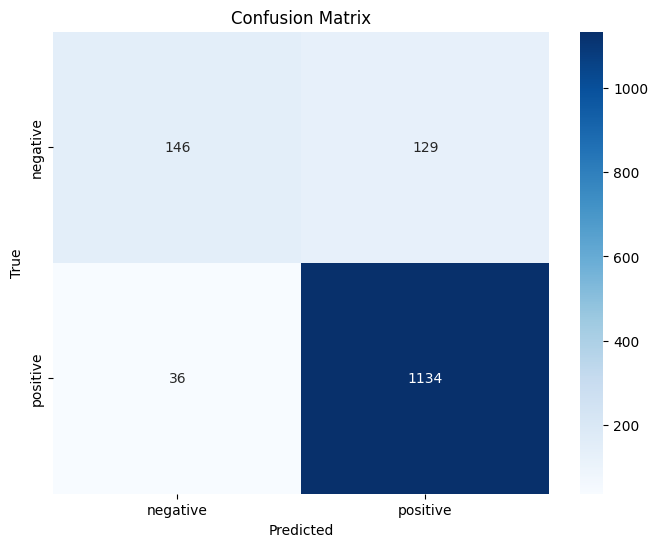

In [13]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels, labels=['negative', 'positive'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
